**Azure AI Agent with File Search Tool**


This Python script demonstrates how to set up an Azure AI Agent with a File Search Tool, enabling it to process user queries and retrieve relevant information from uploaded documents.

Key Features:

* Uploading files to create a vector store for search and retrieval.
* Creating an AI agent powered by GPT-4o-mini with integration of File search tool
* Setting up a conversation thread to interact with the agent dynamically.
* Attaching files to messages for content-based responses.
* Processing user queries with the agent and retrieving responses.

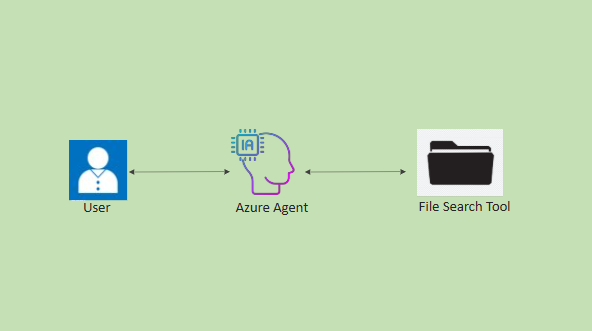

In [1]:
# Installs the Azure AI Projects SDK and Azure Identity library for authentication
#!pip install azure-ai-projects==1.0.0b10 azure-identity==1.21.0 load_dotenv

In [2]:
#Configure environment variables for Azure AI Project
import os
from dotenv import load_dotenv
load_dotenv('agents.env')
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
TENANT_ID = os.getenv("TENANT_ID")
PROJECT_ENDPOINT = os.getenv("PROJECT_ENDPOINT")
print(PROJECT_ENDPOINT)

https://waqkh-mgawgzn2-eastus2.services.ai.azure.com/api/projects/waqkh-mgawgzn2-eastus2_project


In [ ]:
import os
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import FileSearchTool, MessageAttachment, FilePurpose
from azure.identity import ClientSecretCredential

# Configure Azure credentials
credential = ClientSecretCredential(
    tenant_id=os.getenv("TENANT_ID"),
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET")
)

# Initialize Azure AI Project Client
project_client = AIProjectClient(
    credential=credential, endpoint=os.getenv("PROJECT_ENDPOINT")
)

# Upload a file for vector store creation
file = project_client.agents.files.upload_and_poll(file_path='../data/gpt-4-system-card.pdf', purpose=FilePurpose.AGENTS)
print(f"Uploaded file, file ID: {file.id}")

# Create a vector store
vector_store = project_client.agents.vector_stores.create_and_poll(file_ids=[file.id], name="my_vectorstore")
print(f"Created vector store, vector store ID: {vector_store.id}")

# Create a file search tool
file_search_tool = FileSearchTool(vector_store_ids=[vector_store.id])

# Create an AI agent
agent = project_client.agents.create_agent(
    model=os.environ["MODEL_DEPLOYMENT_NAME"],
    name="my-agent-file-searches",
    instructions="You are a helpful agent for File Search , RAG and keep responses to only uploaded file",
    tools=file_search_tool.definitions,
    tool_resources=file_search_tool.resources,
)
print(f"Created agent, agent ID: {agent.id}")

# Create a conversation thread
thread = project_client.agents.threads.create()
print(f"Created thread, thread ID: {thread.id}")

# Interactive conversation loop
while True:
    user_input = input("User: ")
    if user_input.lower() == "end":
        project_client.agents.vector_stores.delete(vector_store.id)
        print("Deleted vector store")
        project_client.agents.delete_agent(agent.id)
        print("Deleted the agent")
        print("Ending the conversation.")
        break

    # Upload file as message attachment
    message_file = project_client.agents.files.upload_and_poll(file_path='../data/gpt-4-system-card.pdf', purpose=FilePurpose.AGENTS)
    attachment = MessageAttachment(file_id=message_file.id, tools=FileSearchTool().definitions)

    # Create a message
    message = project_client.agents.messages.create(
        thread_id=thread.id, role="user", content=user_input, attachments=[attachment]
    )

    # Process the agent's response
    run = project_client.agents.runs.create_and_process(thread_id=thread.id, agent_id=agent.id)

    if run.status == "failed":
        print(f"Run failed: {run.last_error}")
        break

    # Retrieve and display messages
    latest_message = next(msg for msg in project_client.agents.messages.list(thread_id=thread.id) if msg.role == "assistant")
    if agent_response := next((content.text.value for content in latest_message.content if content.type == "text"), None):
        print(f"Agent: {agent_response}")

Uploaded file, file ID: assistant-TQntKEySbW9R6Ktxe7xuZ5
Created vector store, vector store ID: vs_WUqq6nSfsAqTOWvkjDY1IZ7M
Created agent, agent ID: asst_ojBd4hQ7LfWSFuy7ZxPtoKQN
Created thread, thread ID: thread_aNVRFibYi27pTczLsoxPqK9H
Agent: Here are the main key points identified in the data:

1. **Insecure Password Hashing**: The code utilizes MD5 for hashing passwords, which is considered insecure due to vulnerability to collision attacks and speed, making it easier for attackers to perform brute force attacks. Using bcrypt or Argon2 is recommended for improved security【4:0†source】.

2. **SQL Injection Vulnerability**: The code is susceptible to SQL injection as the "fetch" function constructs an SQL query using string concatenation with unsanitized user input. To mitigate this risk, using parameterized queries or prepared statements is advised【4:0†source】.

3. **Hardcoded JWT Secret Key**: The JWT secret key is hardcoded in the "loginHandler" function, which is not a recommended